# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
from utils.data_import import get_sp100

# Options
FIRST_DATE  = "2020-01-01"
LAST_DATE   = "2025-01-01"
N_PROCESSES = 10
MKT_INDEX   = "^SP100"

df_prices = get_sp100(FIRST_DATE,LAST_DATE)

df_prices.head()

Fetching SP100 components
	-> got 101 tickers



C:\Users\jpsan\Documents\GitHub\bootcamp-ds-4ed\utils\data_import.py:52: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  102 of 102 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,^SP100
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.468254,69.823456,78.208046,192.514999,334.429993,44.517937,49.099998,199.607437,195.522339,94.900497,...,267.026367,160.492828,91.948647,46.150036,183.186234,43.349495,46.052402,36.508106,53.661709,1458.130005
2020-01-03,71.763725,69.160706,77.254616,192.194382,331.809998,44.173908,48.599998,198.252319,195.616470,93.748497,...,264.324219,159.356964,91.893524,45.612141,181.729309,42.887955,45.769661,36.185814,53.230289,1446.479980
2020-01-06,72.335556,69.706512,77.659378,190.939362,333.709991,44.208309,48.389999,199.773697,195.565094,95.143997,...,266.159119,157.992142,91.484146,44.988487,181.336349,42.795647,45.495487,36.112137,53.639011,1452.810059
2020-01-07,71.995369,69.308830,77.227638,186.816971,333.390015,43.958885,48.250000,197.894836,191.397919,95.343002,...,264.552460,156.794647,91.326668,44.559734,180.857086,42.319897,45.118496,35.777576,53.200027,1447.359985
2020-01-08,73.153511,69.800072,77.542419,187.183426,337.869995,44.474934,47.830002,198.044510,193.057953,94.598503,...,270.130219,158.511658,91.846298,44.466187,183.953018,42.397999,45.255596,35.654797,52.397755,1455.489990


## Cleaning and Splitting the Data

In [2]:
from utils.data_clean import clean_data

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.80   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

print("Data Cleaned")
print("Training and testing data separated")

Data Cleaned
Training and testing data separated


In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
from random import seed

seed(20220209) # reproducibility

# Garantir que o índice seja do tipo datetime
df_test.index = pd.to_datetime(df_test.index)

# Criar os pontos de corte trimestrais (4 períodos)
quarters = pd.date_range(start=df_test.index.min(), end=df_test.index.max(), periods=5)  # 5 porque gera 4 intervalos

# Criar os subconjuntos trimestrais
quarters_data = {
    "Q1": df_test.loc[(df_test.index >= quarters[0]) & (df_test.index < quarters[1])],
    "Q2": df_test.loc[(df_test.index >= quarters[1]) & (df_test.index < quarters[2])],
    "Q3": df_test.loc[(df_test.index >= quarters[2]) & (df_test.index < quarters[3])],
    "Q4": df_test.loc[(df_test.index >= quarters[3]) & (df_test.index <= quarters[4])]
}


print("Testing data separated in trimesters")
for q, df_part in quarters_data.items():
    print(f"{q}: {len(df_part)} observações, de {df_part.index.min().date()} a {df_part.index.max().date()}")

# --- Configurações ---
mkt_index = "^SP100"
current_train = df_train.copy()
portfolio_history = {}  # para armazenar pesos
returns_history = {}    # para armazenar retornos trimestrais do portfólio

current_train.head()

Testing data separated in trimesters
Q1: 62 observações, de 2024-01-02 a 2024-04-01
Q2: 63 observações, de 2024-04-02 a 2024-07-01
Q3: 63 observações, de 2024-07-02 a 2024-09-30
Q4: 64 observações, de 2024-10-01 a 2024-12-31


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,^SP100
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.009722,-0.009492,-0.012191,-0.001665,-0.007834,-0.007728,-0.010183,-0.006789,0.000481,-0.012139,...,-0.010119,-0.007077,-0.000599,-0.011655,-0.007953,-0.010647,-0.006140,-0.008828,-0.008040,-0.007990
2020-01-06,0.007968,0.007892,0.005239,-0.006530,0.005726,0.000779,-0.004321,0.007674,-0.000263,0.014886,...,0.006942,-0.008565,-0.004455,-0.013673,-0.002162,-0.002152,-0.005990,-0.002036,0.007678,0.004376
2020-01-07,-0.004703,-0.005705,-0.005559,-0.021590,-0.000959,-0.005642,-0.002893,-0.009405,-0.021308,0.002092,...,-0.006036,-0.007579,-0.001721,-0.009530,-0.002643,-0.011117,-0.008286,-0.009264,-0.008184,-0.003751
2020-01-08,0.016086,0.007088,0.004076,0.001962,0.013438,0.011739,-0.008705,0.000756,0.008673,-0.007809,...,0.021084,0.010951,0.005690,-0.002099,0.017118,0.001846,0.003039,-0.003432,-0.015080,0.005617
2020-01-09,0.021241,0.007708,0.002668,0.008907,0.007636,0.011023,0.023834,0.002980,0.003768,0.004799,...,-0.005677,-0.005111,0.002314,0.000351,0.006930,-0.004146,-0.001704,0.010331,0.007656,0.007544


## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [ ]:
# bons valores para testar
# escolher valores iguais a 3 ou maiores

# max_assets = 3  
# time = 2

# max_assets = 10  
# time = 5

In [11]:
# Ajuste os parametros abaixo para testar diferentes
# quantidades de ações e de tempo para otimizar
# o 'i' é apenas para printar qual trimestre estamos otimizando
max_assets = 30  # escolher valores iguais a 3 ou maiores
time = 60
i = 1

# para cada trimestre
for q_name, df_quarter in quarters_data.items():
    # Adiciona trimestre ao conjunto de treino
    current_train = pd.concat([current_train, df_quarter])

    # Separa dados
    r_mkt = current_train[mkt_index]
    r_it = current_train.drop(mkt_index, axis=1)
    tickers = list(r_it.columns)
        
    # Create an empty model
    m = gp.Model('gurobi_index_tracking')

    # PARAMETERS 
    # w_i: the i_th stock gets a weight w_i 
    w = pd.Series(m.addVars(tickers, 
                             lb = 0,
                             ub = 1,
                             vtype = gp.GRB.CONTINUOUS), 
                   index=tickers)
    # z_i: the i_th stock gets a binary z_i
    z = pd.Series(m.addVars(tickers,
                            vtype = gp.GRB.BINARY),
                    index=tickers)

    # CONSTRAINTS
    # sum(w_i) = 1: portfolio budget constrain
    m.addConstr(w.sum() == 1, 'port_budget')
    # w_i <= z_i: w_i can only have a value > 0 if z_i > 0 (or z_i = 1 in this case)
    for i_ticker in tickers:
        m.addConstr(w[i_ticker] <= z[i_ticker], 
                    f'dummy_restriction_{i_ticker}')  
    # sum(z_i) <= max_assets: number of assets constraint
    m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')
    
    m.update()
    
    my_error = r_it.dot(w) - r_mkt
    
    # set objective function, minimize the sum of squared tracking errors between portfolio and market returns
    m.setObjective(
        gp.quicksum(my_error.pow(2)), 
        gp.GRB.MINIMIZE)     

    print(f"Starting the optimization process for the {i} trimester ")
    print(f"It will take {time} seconds to it's conclusion")
    
    # Optimize model
    m.setParam('OutputFlag', 0)
    m.setParam('TimeLimit', time) # in secs
    #m.setParam('MIPGap', 0.05) # in secs
    m.optimize()
    
    # --- Resultados ---
    weights = {t: w[t].X for t in tickers if w[t].X > 0.001}
    portfolio_history[q_name] = weights  # guarda o portfólio

    print(f"✅ {len(weights)} ações selecionadas:")
    for t, val in sorted(weights.items(), key=lambda x: -x[1]):
        print(f"   {t}: {val*100:.2f}%")

    i = i + 1

    # --- Avaliar o desempenho no trimestre ---
    if q_name in quarters_data:
        r_mkt_test = df_quarter[mkt_index]
        r_it_test = df_quarter.drop(mkt_index, axis=1)

        # calcula o retorno diário do portfólio
        port_ret = r_it_test[list(weights.keys())].dot(np.array(list(weights.values())))
        # aramenaz
        returns_history[q_name] = port_ret

# --- Pós-processamento: retorno acumulado ---
portfolio_cumret = pd.concat(returns_history).groupby(level=1).sum().cumsum()
market_cumret = df_test[mkt_index].cumsum()
print("Fim do processo de otimização")

Starting the optimization process for the 1 trimester 
It will take 60 seconds to it's conclusion
✅ 20 ações selecionadas:
   AAPL: 10.27%
   MSFT: 8.98%
   AMZN: 6.90%
   GOOG: 6.75%
   KO: 6.63%
   NVDA: 6.40%
   PG: 6.07%
   JNJ: 5.94%
   JPM: 5.87%
   GD: 3.87%
   V: 3.80%
   HD: 3.75%
   AVGO: 3.72%
   LLY: 3.52%
   CAT: 3.47%
   XOM: 3.45%
   META: 3.13%
   USB: 2.98%
   ORCL: 2.61%
   TSLA: 1.87%
Starting the optimization process for the 2 trimester 
It will take 60 seconds to it's conclusion
✅ 20 ações selecionadas:
   AAPL: 10.13%
   MSFT: 8.47%
   JPM: 7.34%
   KO: 7.16%
   GOOG: 6.77%
   AMZN: 6.56%
   NVDA: 6.32%
   PG: 6.06%
   JNJ: 5.97%
   HON: 4.69%
   XOM: 4.03%
   AVGO: 3.84%
   CAT: 3.48%
   HD: 3.47%
   META: 3.24%
   LLY: 3.15%
   ORCL: 2.89%
   CVS: 2.41%
   CRM: 2.12%
   TSLA: 1.88%
Starting the optimization process for the 3 trimester 
It will take 60 seconds to it's conclusion
✅ 20 ações selecionadas:
   AAPL: 9.89%
   MSFT: 8.73%
   AMZN: 6.96%
   JPM: 6.80%
 

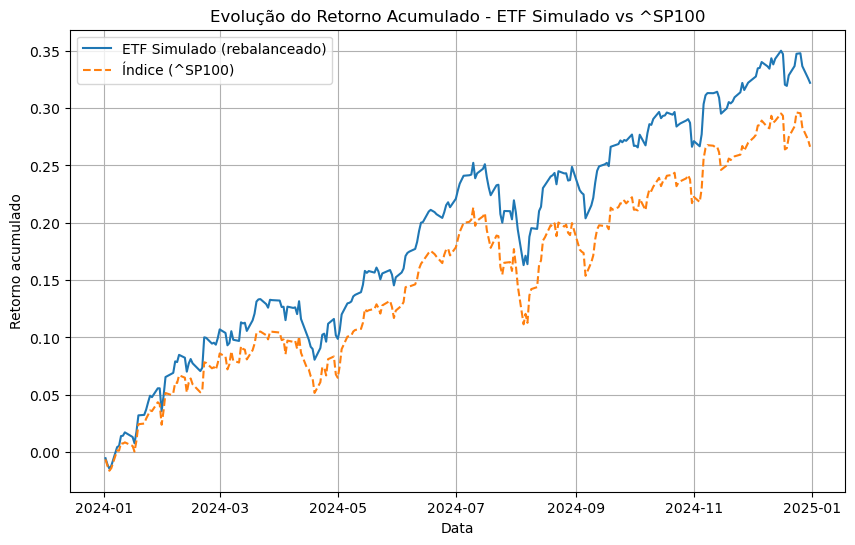

In [12]:
# --- Plot comparativo ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_cumret.index, portfolio_cumret, label='ETF Simulado (rebalanceado)')
plt.plot(market_cumret.index, market_cumret, label='Índice (^SP100)', linestyle='--')
plt.title(f"Evolução do Retorno Acumulado - ETF Simulado vs {mkt_index}")
plt.xlabel("Data")
plt.ylabel("Retorno acumulado")
plt.legend()
plt.grid(True)
plt.show()